基本原理和离散动作是一样的,连续动作的概率使用高斯密度函数计算即可.

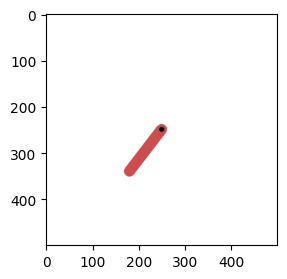

In [ ]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()


'''
高中生版本解說

  我們換了一個新遊戲，叫做「倒立擺 (Pendulum)」。

   * 遊戲目標：想像一根掛在時鐘中心的指針，它會自然下垂。你的目標是施加一個力（力矩），讓這根指針能反抗地心引力，成功地向上豎起來，並保持直立
     。
   * 連續動作：你施加的力，不像之前只能「向左」或「向右」，而是可以施加任意大小的力（比如 +0.5, -1.8 等），這就是「連續動作」。

  這個 MyWrapper 同樣修改了遊戲規則，主要有兩點不同：

   1. 動作轉換器：我們的演員大腦，它習慣輸出 -1 到 +1 之間的力。但這個遊戲引擎，它需要接收 -2 到 +2 之間的力。所以 step 函數裡加了一句 [action
      * 2]，就像一個「變速箱」，自動把演員的輸出乘以 2，來滿足遊戲引擎的要求。

   2. 分數標準化：這個遊戲原始的計分方式很奇怪，分數都是像 -13.2、-5.7 這樣的負數。為了讓我們的評論家大腦更容易學習和判斷，reward = (reward +
      8) / 8 這行程式碼把這些奇怪的分數，全部轉換到 -1 到 +1
      這個比較「標準」的區間內。這就像把華氏溫度轉換成攝氏溫度，數字更規整，更容易比較和學習。

  專業術語解說

  這個 Cell 為 Pendulum-v1 環境定義了一個新的 Wrapper，主要進行了動作空間映射和獎勵歸一化。

   1. 環境 (`Pendulum-v1`):
       * 這是一個經典的連續控制任務。
       * 狀態空間 (State Space)：3 維，包含 [cos(theta), sin(theta), a_velocity]，即角度的餘弦、正弦和角速度。
       * 動作空間 (Action Space)：1 維，代表施加的力矩 (torque)，其有效範圍是 [-2.0, 2.0]。

   2. 動作空間映射 (Action Space Mapping):
       * self.env.step([action * 2]) 這一行至關重要。它解決了策略網路的輸出範圍和環境要求的動作範圍不匹配的問題。
       * 在連續控制中，策略網路的輸出層通常會使用 tanh 激活函數，它的值域是 [-1, 1]。這樣做可以避免網路輸出的值無限大，讓訓練更穩定。
       * 因此，我們需要將 tanh 輸出的 [-1, 1] 範圍的動作，線性地映射到環境所需的 [-2, 2] 範圍。這裡的 * 2 就是在執行這個映射。

   3. 獎勵歸一化 (Reward Normalization):
       * reward = (reward + 8) / 8 是一種常見且有效的獎勵塑造 (Reward Shaping) 技術。
       * Pendulum-v1 的原始獎勵是一個與角度和角速度相關的代價函數 (cost)，其範圍大致在 [-16.27,
         0]。直接使用這個範圍的獎勵，可能會因為其數值過大且分佈不均，導致價值網路的學習不穩定。
       * 通過 + 8 和 / 8，我們將獎勵信號歸一化到一個更穩定、更對稱的範圍（約 [-1, 1]）。這有助於穩定 Critic
         的訓練，防止梯度爆炸或消失，並可能加速學習過程。
'''


'''
，獎勵歸一化確實是為了穩定價值網路 (Critic) 的訓練，而穩定的價值網路，是整個 PPO 演算法能夠成功收斂的基石。

  讓我來解釋這背後的因果關係。

  ---

  梯度從何而來？

  首先，我們要記住，梯度爆炸或消失，問題出在價值網路 (`model_value`) 的訓練過程中。

  價值網路的學習目標，是讓自己的預測 value 盡可能地接近「標準答案」target。它的損失函數是：
  Loss = (value - target)²

  在反向傳播時，第一步計算的梯度，就是這個 Loss 對 value 的導數，也就是：
  Gradient ≈ 2 * (value - target)

  這就是關鍵點：梯度的初始大小，直接取決於 (value - target) 這個差值的大小。

  ---

  兩種情境對比

  讓我們用倒立擺的例子，來對比一下「歸一化」和「不歸一化」的差別。

  情境一：不使用獎勵歸一化 (有風險)

   * 獎勵範圍：倒立擺的原始獎勵 reward 範圍約為 [-16, 0]。
   * Target 的範圍：target 的計算公式是 reward + 0.98 * V(s_next)。這意味著 target 的值也會是很大的負數，比如 -15, -12 等。
   * 訓練初期：在訓練剛開始時，你的價值網路 model_value 還是一個「菜鳥」，它的權重是隨機的，所以它的輸出 value 可能是一個接近 0 的小數，比如
     0.5。
   * 梯度計算：
       * value (預測值) = 0.5
       * target (標準答案) = -15
       * Gradient ≈ 2 * (0.5 - (-15)) = 31
   * 問題所在：31 是一個非常大的梯度值！ 當這個巨大的梯度從輸出層開始，通過鏈式法則反向傳播回網路的每一層時，它會被逐層放大（或縮小）。這極有
     可能導致網路底層的權重發生劇烈的、爆炸性的更新。
   * 結果：網路的權重可能會瞬間變成 inf (無窮大) 或 NaN (非數)，整個模型直接「炸掉」，訓練失敗。這就是梯度爆炸。

  情境二：使用獎勵歸一化 (更穩定)

   * 獎勵範圍：通過 (reward + 8) / 8，我們把獎勵 reward 的範圍縮放到 [-1, 1] 之間。
   * Target 的範圍：現在，target 的值也會被限制在一個很小的、可預測的範圍內。
   * 訓練初期：model_value 的輸出 value 仍然是 0.5。
   * 梯度計算：
       * 原始 reward = -15，歸一化後 reward = (-15 + 8) / 8 = -0.875。
       * value (預測值) = 0.5
       * target (標準答案) ≈ -0.875
       * Gradient ≈ 2 * (0.5 - (-0.875)) = 2.75
   * 優勢：2.75 是一個溫和得多的梯度值。當這個小而穩定的梯度回傳時，網路的權重只會進行平滑的、微小的調整。
   * 結果：訓練過程非常穩定，網路的權重會逐步地、可控地向著正確的方向收斂，有效避免了梯度爆炸或消失的風險。

  總結

  可以把獎勵歸一化，看作是為我們的價值網路（評論家）提供了一套「溫和的、標準化的課程」。

   * 不歸一化，就像是讓一個小學生直接去解大學微積分，題目太難（target 值太大），他要麼當場崩潰（梯度爆炸），要麼完全放棄（梯度消失）。
   * 歸一化，則是把大學微積分的知識，拆解成從「加減乘除」到「代數」再到「極限」的標準化課程。學生每一步學到的知識都在可控範圍內，他的能力（網
     路權重）因此能夠穩定、持續地成長。

  所以，獎勵歸一化通過約束 Critic 損失函數中目標值的範圍，間接地控制了梯度的初始大小，從而保護了整個神經網路在反向傳播過程中免受劇烈衝擊，這
  是保證深度強化學習訓練穩定性的關鍵一步。

'''

In [2]:
import torch


#定义模型
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
        )
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )
        self.sigma = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        state = self.s(state)

        return self.mu(state), self.sigma(state).exp()


model_action = Model()

model_value = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_action(torch.randn(2, 3)), model_value(torch.randn(2, 3))

((tensor([[0.0291],
          [0.0673]], grad_fn=<TanhBackward0>),
  tensor([[0.8901],
          [0.8493]], grad_fn=<ExpBackward0>)),
 tensor([[ 0.0453],
         [-0.1344]], grad_fn=<AddmmBackward0>))


  平衡車 (CartPole-v1) 的 4 個數字

  平衡車的狀態是一個包含 4 個數字的列表，它們共同描述了「車」和「杆」的瞬時情況：

   1. 車的位置 (Cart Position)：
       * 意義：小車在水平軌道上的位置。
       * 數值：0.0 代表軌道正中央。正數代表在右邊，負數代表在左邊。

   2. 車的速度 (Cart Velocity)：
       * 意義：小車的移動速度和方向。
       * 數值：正數代表向右移動，負數代表向左移動。

   3. 杆的角度 (Pole Angle)：
       * 意義：杆子偏離垂直線的角度。
       * 數值：0.0 代表完美垂直。正數代表向右傾斜，負數代表向左傾斜。

   4. 杆的角速度 (Pole Angular Velocity)：
       * 意義：杆子頂端的摔倒速度。
       * 數值：描述了杆子角度的變化率。如果杆子正在向右倒，這個值就是正的。

  所以，演員大腦就是根據這四個數字（車的位置、車速、杆的角度、杆的角速度）來決定下一步是向左還是向右推小車。

  ---

  倒立擺 (Pendulum-v1) 的 3 個數字

  倒立擺的狀態稍微有點不同，它用 3 個數字來描述：

   1. 角度的餘弦 `cos(theta)`
   2. 角度的正弦 `sin(theta)`
   3. 角速度 (Angular Velocity)

  你可能會問：為什麼不直接用角度 `theta`，而是要用 `cos(theta)` 和 `sin(theta)` 這麼麻煩？

  這是一個非常聰明的設計，為了解決一個叫做「不連續性」的問題。

   * 問題所在：角度是有循環的。359 度和 1 度在物理上幾乎是同一個位置，但 359 和 1
     這兩個數字本身卻相差很遠。如果直接把角度數字餵給神經網路，它很難理解這種「循環」的特性，可能會在 0 度附近做出非常奇怪的決策。
   * 解決方案：通過 cos(theta) 和 sin(theta)，我們可以把一個一維的角度，完美地轉換成一個二維圓上的點 (x, y)。當角度從 359 度平滑地過渡到 1
     度時，這個點也會在圓上平滑地移動。這樣，神經網路就能更好地理解角度的連續性和週期性，做出更合理的判斷。

  最後一個數字角速度 (Angular Velocity) 和平衡車的杆的角速度意義一樣，代表了擺杆正在旋轉的速度和方向。

  所以，在倒立擺遊戲中，演員大腦是根據 (cos(theta), sin(theta), 角速度) 這三個數字，來決定要施加多大的力矩。

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        mu, sigma = model_action(torch.FloatTensor(s).reshape(1, 3))
        a = random.normalvariate(mu=mu.item(), sigma=sigma.item())

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 3)
    action = torch.FloatTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)
    next_state = torch.FloatTensor(next_state).reshape(-1, 3)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()


state, action, reward, next_state, over, reward_sum = play()

reward_sum

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\User\AppData\Local\Temp\ipykernel_44956\3994207745.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor(state).reshape(-1, 3)


30.417152404785156

 高中生版本解說

  這個新版的「遊戲記錄員」play 函數，主要有以下幾點變化：

   1. 獲取行動指南：記錄員不再從演員那裡拿到一個像 [0.7, 0.3]
      的機率列表，而是拿到一個更高級的「行動指南」——一個高斯分佈（鐘形曲線），這個分佈由「最佳猜測 mu」和「不確定性 sigma」共同定義。

   2. 選擇具體動作：記錄員使用 random.normalvariate() 這個工具，在這個鐘形曲線上隨機抽取一個點。這個點就是一個具體的、連續的數值（比如
      -0.85、1.23），代表了這一步要施加的力的大小。這就像在一個靶子上射擊，mu 是靶心，sigma 決定了你的射擊散佈範圍，而 a
      就是你這一槍實際打中的位置。

   3. 記錄浮點數動作：因為動作不再是 0 或 1，而是一個浮點數，所以在最後整理數據時，action 列表被轉換成 FloatTensor。

  其他部分，如記錄狀態、獎勵、是否結束等，都和之前完全一樣。

  專業術語解說

  這個 play 函數的核心改動在於策略的執行和動作的採樣。

   1. 策略參數化: mu, sigma = model_action(...) 這一行執行了策略網路，獲取了定義高斯策略 $\mathcal{N}(\mu, \sigma)$ 的兩個參數。

   2. 動作採樣: a = random.normalvariate(...) 從上述定義的高斯分佈中採樣一個連續動作值 a。這是執行隨機高斯策略的具體實現。

   3. 數據類型: 由於動作 a 是連續的浮點數，因此在函數末尾，action 列表被轉換為 torch.FloatTensor，以匹配其數據類型。

  一個關於梯度的重要說明

  你可能會注意到，這裡使用的是 Python 內建的 random.normalvariate，而不是我們之前討論過的、可微分的 dist.rsample()。這是一個非常關鍵的區別：

   * 在 `play` 函數中，這樣做是完全可以的。因為 play
     函數的唯一目的是收集數據。在這個階段，我們只是在執行策略，並不需要計算梯度和進行反向傳播。我們只需要一個具體的動作 a 來和環境互動。
   * 梯度在哪裡？梯度的問題會在 train_action 函數中解決。在訓練時，我們會根據儲存的狀態 s，重新計算一次 mu 和 sigma，然後用 PyTorch 的
     distributions.Normal 來創建一個可微分的分佈，再用這個分佈去計算我們儲存的動作 a 的對數機率 log_prob(a)。

  這種將「執行採樣」和「訓練時的機率計算」分離開來的做法，在實作上是完全可行的，並且能正常工作。

In [4]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=5e-3)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

  高中生版本解說

  這個 cell 依然是在為我們的兩個大腦（演員和評論家）聘請「專屬教練 (`Optimizer`)」。

   * 功能不變：和上次一樣，我們還是聘請了 Adam 這位全能教練，並且也準備了 requires_grad
     這個「訓練開關」，用來在訓練時凍結其中一個大腦。整個工作的基本模式沒有任何變化。

   * 唯一的調整：學習率 (`lr`)：
       * 這次，我們給兩位教練的「學習率」都調低了。
           * 演員的學習率從 0.001 降到了 0.0005。
           * 評論家的學習率從 0.01 降到了 0.005。
       * 為什麼要調低？ 因為「倒立擺」這個新遊戲比「平衡車」更精細、更複雜。我們可以把它想像成，從學「走路」變成了學「走鋼絲」。在這種更需要技
         巧和平衡的任務中，我們需要讓大腦的學習過程更謹慎、更平滑。較低的學習率，就意味著教練每次只會對大腦進行更微小的調整，一步一個腳印，避
         免因為某次調整過大而「從鋼絲上掉下來」（即策略崩潰）。

  專業術語解說

  此 cell 的功能與離散動作版本中的對應 cell 完全相同：初始化 Actor 和 Critic 的 Adam 優化器，並定義 requires_grad 輔助函數。

  這展示了 PPO 演算法中不同模塊的獨立性——無論策略的具體形式如何（離散或連續），優化器的設置和梯度控制的邏輯都可以保持不變。

  唯一的、但也是很重要的改動是超參數（Hyperparameter）的調整：

   * 學習率 (Learning Rates)：兩個網路的學習率都被調低了（演員：1e-3 -> 5e-4；評論家：1e-2 -> 5e-3）。
   * 調整原因：連續控制問題的策略空間通常比離散問題更複雜、更敏感。較低的學習率有助於增強訓練的穩定性。它使得權重更新的步長變小，減少了因某次
     梯度更新過大而導致策略性能急劇下降的風險，讓策略能夠在複雜的「損失地形」上進行更平穩的搜索。
   * 學習率比例：儘管絕對值降低了，但評論家的學習率仍然是演員的 10 倍，這保留了讓價值函數比策略更快收斂的設計思想。

In [5]:
def train_value(state, reward, next_state, over):
    requires_grad(model_action, False)
    requires_grad(model_value, True)

    #计算target
    with torch.no_grad():
        target = model_value(next_state)
    target = target * 0.98 * (1 - over) + reward

    #每批数据反复训练10次
    for _ in range(10):
        #计算value
        value = model_value(state)

        loss = torch.nn.functional.mse_loss(value, target)
        loss.backward()
        optimizer_value.step()
        optimizer_value.zero_grad()

    #减去value相当于去基线
    return (target - value).detach()


value = train_value(state, reward, next_state, over)

value.shape

torch.Size([200, 1])

In [6]:
def train_action(state, action, value):
    requires_grad(model_action, True)
    requires_grad(model_value, False)

    #计算优势函数
    delta = []
    for i in range(len(value)):
        s = 0
        for j in range(i, len(value)):
            s += value[j] * (0.9 * 0.9)**(j - i)
        delta.append(s)
    delta = torch.FloatTensor(delta).reshape(-1, 1)

    #更新前的动作概率
    with torch.no_grad():
        mu, sigma = model_action(state)
        prob_old = torch.distributions.Normal(mu, sigma).log_prob(action).exp()

    #每批数据反复训练10次
    for _ in range(10):
        #更新后的动作概率
        mu, sigma = model_action(state)
        prob_new = torch.distributions.Normal(mu, sigma).log_prob(action).exp()

        #求出概率的变化
        ratio = prob_new / prob_old

        #计算截断的和不截断的两份loss,取其中小的
        surr1 = ratio * delta
        surr2 = ratio.clamp(0.8, 1.2) * delta

        loss = -torch.min(surr1, surr2).mean()

        #更新参数
        loss.backward()
        optimizer_action.step()
        optimizer_action.zero_grad()

    return loss.item()


train_action(state, action, value)

0.01315974723547697

In [7]:
def train():
    model_action.train()
    model_value.train()

    #训练N局
    for epoch in range(1000):
        #一个epoch最少玩N步
        steps = 0
        while steps < 200:
            state, action, reward, next_state, over, _ = play()
            steps += len(state)

            #训练两个模型
            delta = train_value(state, reward, next_state, over)
            loss = train_action(state, action, delta)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 0.24221140146255493 28.25833005607128
100 0.10609608888626099 72.09614181518555
200 0.159645676612854 41.67578239440918
300 -0.5503265857696533 165.66928825378417
400 -0.632102370262146 157.85325393676757
500 -0.8215871453285217 162.35944175720215
600 0.06191960349678993 164.19886589050293
700 -1.5193116664886475 135.93767490386963
800 -0.41928574442863464 108.27153968811035
900 -0.043920379132032394 168.85371627807618


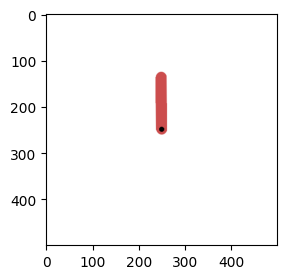

146.6409149169922

In [8]:
play(True)[-1]